<a href="https://colab.research.google.com/github/namtoptall/DataScience/blob/main/rec_sys_milestone_project_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bước 2 : xây dựng hệ thống

In [1]:
# check-gpu
!nvidia-smi

Mon Aug 26 20:53:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# kết nối google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
files.upload()  # Thực hiện tải tệp kaggle.json lên từ máy tính

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"namdz242221","key":"de869a9575f6ac51974bca65557d88a7"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d namdz242221/dsp305x-01-a-vn-dataset
!unzip dsp305x-01-a-vn-dataset.zip -d /content/dataset

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/dataset/DSP305x_01-A_VN-dataset/train/Plumeria/001737.jpg  
  inflating: /content/dataset/DSP305x_01-A_VN-dataset/train/Plumeria/001739.jpg  
  inflating: /content/dataset/DSP305x_01-A_VN-dataset/train/Plumeria/001740.jpg  
  inflating: /content/dataset/DSP305x_01-A_VN-dataset/train/Plumeria/001741.jpg  
  inflating: /content/dataset/DSP305x_01-A_VN-dataset/train/Plumeria/001743.jpg  
  inflating: /content/dataset/DSP305x_01-A_VN-dataset/train/Plumeria/001744.jpg  
  inflating: /content/dataset/DSP305x_01-A_VN-dataset/train/Plumeria/001745.jpg  
  inflating: /content/dataset/DSP305x_01-A_VN-dataset/train/Plumeria/001746.jpg  
  inflating: /content/dataset/DSP305x_01-A_VN-dataset/train/Plumeria/001748.jpeg  
  inflating: /content/dataset/DSP305x_01-A_VN-dataset/train/Plumeria/001751.jpg  
  inflating: /content/dataset/DSP305x_01-A_VN-dataset/train/Plumeria/001752.png  
  inflating: /content/dataset/DSP305x_01

In [6]:
from google.colab import files
files.upload()  # Thực hiện tải ETL_functions.py lên từ máy tính

Saving ETL_functions.py to ETL_functions (1).py


{'ETL_functions (1).py': b'import os\r\nimport numpy as np\r\nimport pandas as pd\r\nimport tensorflow as tf\r\nfrom PIL import Image\r\nfrom sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix\r\nimport itertools\r\nimport matplotlib.pyplot as plt\r\nimport datetime\r\n# set the max image pixels to None\r\nImage.MAX_IMAGE_PIXELS = None\r\nimport os\r\nfrom PIL import Image, UnidentifiedImageError\r\n\r\n# Constants\r\nTARGET_IMG_SIZE = 256\r\n\r\nCLASS_LABELS = [\r\n    "Lotus", \r\n    "Chrysanthemum",\r\n    "Peony",\r\n    "Orchid",\r\n    "Sunflower",\r\n    "Bougainvillea",\r\n    "Rose",\r\n    "peach blossom",\r\n    "Plumeria",\r\n    "Plum blossom"\r\n]\r\n\r\ndef extract_image_info(image_path: str) -> dict:\r\n    """\r\n    Extract information from an image file.\r\n\r\n    :param image_path: Full path to the image file.\r\n    :return: A dictionary with extracted image information or None if the file is not a valid image.\r\n    """\r\n

In [7]:
from tensorflow.keras.models import load_model

# Đường dẫn đến mô hình đã lưu
fine_tuned_model_path = "/content/drive/MyDrive/Funix_Capstone_model.keras"

# Tải mô hình đã fine-tune
fine_tuned_model = load_model(fine_tuned_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Tạo một mô hình chỉ để trích xuất đặc trưng (bỏ đi các lớp đầu ra cuối cùng)
feature_extractor = Model(inputs=fine_tuned_model.input, outputs=fine_tuned_model.get_layer("global_average_pooling2d_1").output)

# Hàm để trích xuất đặc trưng từ hình ảnh
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Chuẩn hóa ảnh
    features = model.predict(img_array)
    return features.flatten()


In [10]:
# Trích xuất đặc trưng từ tập test
test_dir = "/content/dataset/DSP305x_01-A_VN-dataset/test"  # Thư mục chứa các ảnh trong tập test
feature_list = []
image_list = []

for class_dir in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_dir)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if os.path.isfile(img_path):
                features = extract_features(img_path, feature_extractor)
                feature_list.append(features)
                image_list.append(img_path)

feature_array = np.array(feature_list)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_images(input_img_path, feature_array, image_list, model, top_k=5):
    input_features = extract_features(input_img_path, model)
    similarities = cosine_similarity([input_features], feature_array)
    similar_indices = similarities[0].argsort()[-top_k:][::-1]
    recommended_images = [image_list[i] for i in similar_indices]
    return recommended_images

In [15]:
from google.colab import files
files.upload()  # tải một ảnh Hoa bất kì

Saving test_img.jpg to test_img.jpg


{'test_img.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x01\xd8ICC_PROFILE\x00\x01\x01\x00\x00\x01\xc8lcms\x02\x10\x00\x00mntrRGB XYZ \x07\xe2\x00\x03\x00\x14\x00\t\x00\x0e\x00\x1dacspMSFT\x00\x00\x00\x00sawsctrl\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-hand\xb4\xaa\xdd\x1f\x13\xc8\x03<\xf5Q\x14E(z\x98\xe2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\tdesc\x00\x00\x00\xf0\x00\x00\x00^cprt\x00\x00\x01\x0c\x00\x00\x00\x0cwtpt\x00\x00\x01\x18\x00\x00\x00\x14rXYZ\x00\x00\x01,\x00\x00\x00\x14gXYZ\x00\x00\x01@\x00\x00\x00\x14bXYZ\x00\x00\x01T\x00\x00\x00\x14rTRC\x00\x00\x01h\x00\x00\x00`gTRC\x00\x00\x01h\x00\x00\x00`bTRC\x00\x00\x01h\x00\x00\x00`desc\x00\x00\x00\x00\x00\x00\x00\x04uP3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00text\x00\x00\x00\x00CC0\x00XYZ \x00\x00\x00\x00\x00\x00\xf3Q\x00\x01\x00\x00\x00\x01\x16\xc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


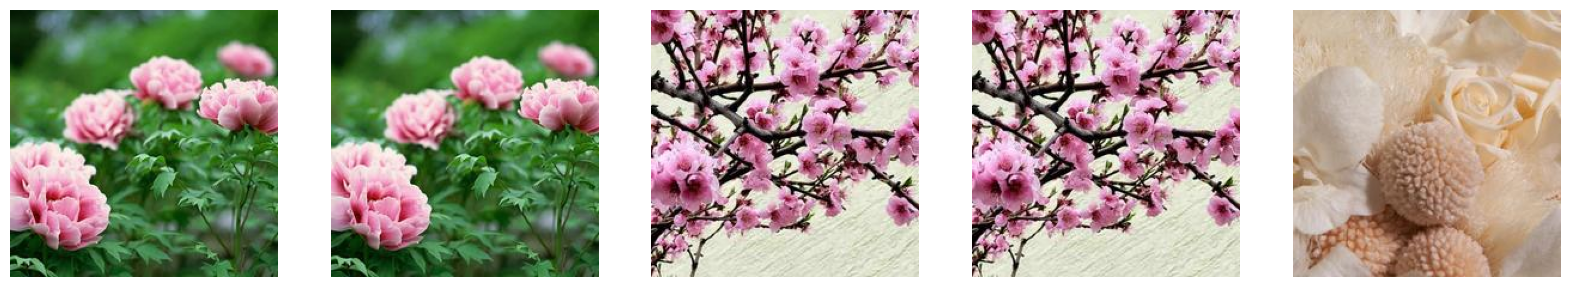

In [16]:
import matplotlib.pyplot as plt

def show_images(image_paths):
    plt.figure(figsize=(20, 5))
    for i, img_path in enumerate(image_paths):
        img = image.load_img(img_path, target_size=(224, 224))
        plt.subplot(1, len(image_paths), i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Thử nghiệm với một ảnh đầu vào
input_image_path = '/content/test_img.jpg'
recommended_images = recommend_images(input_image_path, feature_array, image_list, feature_extractor)
show_images(recommended_images)
